#Problem description, personal motivation and goal of this project

##Problem description

About a month ago, my familiy and me were the unlucky winners of the Covid-19 lottery. Probably as anywhere in the world, health protection services are overstrained and my home country of Serbia is not an exception. In an effort to release the pressure that was put on hospitals where secondary and tertiary care is provided, the governement opened a bunch of small Covid clinics in primary health care centres throughout the country. The idea was to diagnose and treat Covid infections at a local level and to send severe cases of infections to medical centres of secondary and tertiary care. But the problem which arose under the radar is that the staff of this primary healthcare centres doesn't have enough experience or just isn't qualified enough in diagnosing pneumonia cases from X-ray scans, which is not surprising since pneumonia before Covid was pretty uncommon. As you can imagine the potentially fatal outcome can be a product of not making a proper decision whether the patient has pneumonia or not.

##Personal motivation

And now for the personal motivation for this project. Two of my family members and me were diagnosed as not having a pneumonia by one of this local Covid clinics, since our symptoms weren't improving after few days we decided to send our scans to a pulmonologist who works in one of the Covid hospitals, where he told us that we all actually have pneumonia and that we should use different medication than we were prescribed originally, about two weeks later we were better.

##Goal

The goal of this project is to create X-ray scan classificator which will give an estimation whether pneumonia is or is not present in the scan. The plan is to use few pretrained networks, decide on the best performing and use the best model to check what will be the verdict whether pneumonia was or wasn't present in scans of my family and me.

#Imports, connecting Google colab to Kaggle, dataset downloading and path forming

In [ ]:
import tensorflow as tf
from google.colab import files
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator as img_gen
import os
from pathlib import Path
import zipfile
from matplotlib.image import imread
from keras.applications.densenet import DenseNet121
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#Uploading kaggle api key to colab
! pip install -q kaggle
files.upload()

In [ ]:
#We are training on GPU
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
else:
  print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
#Downloading dataset from Kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia/

100% 2.29G/2.29G [00:28<00:00, 60.5MB/s]
100% 2.29G/2.29G [00:29<00:00, 84.9MB/s]


In [ ]:
#Extracting the contents of zip
zfile = zipfile.ZipFile("/content/chest-xray-pneumonia.zip")
zfile.extractall("/content/dataset/pneumonia")
!ls "/content/dataset/pneumonia/chest_xray"

chest_xray  __MACOSX  test  train  val


In [ ]:
#Creating paths
train_dir = Path("../content/dataset/pneumonia/chest_xray/train")
val_dir   = Path("../content/dataset/pneumonia/chest_xray/val")
test_dir  = Path("../content/dataset/pneumonia/chest_xray/test")


In [ ]:
#Grabbing paths and dividing them to train, validation and test
path_train= list(train_dir.glob(r'*/*.jpeg'))
path_test= list(test_dir.glob(r'*/*.jpeg'))
path_val = list(val_dir.glob(r'*/*.jpeg'))

#Creating dataframes

In [ ]:
#Extracting labels from name of each image
train_labels = []
val_labels   = []
test_labels  = []
for path in range(len(path_train)):
  value = path_train[path].parents[0].stem
  train_labels.append(value)

for path in range(len(path_val)):
  value = path_val[path].parents[0].stem
  val_labels.append(value)

for path in range(len(path_test)):
  value = path_test[path].parents[0].stem
  test_labels.append(value)

In [ ]:
train_labels= pd.Series(train_labels, name= 'Type')
test_labels= pd.Series(test_labels, name= 'Type')
val_labels = pd.Series(val_labels, name= 'Type')

images_train= pd.Series(path_train, name= 'Scan').astype(str)
images_test = pd.Series(path_test, name= 'Scan').astype(str)
images_val = pd.Series(path_val, name= 'Scan').astype(str)

In [ ]:
df_train= pd.concat([images_train, train_labels], axis=1)
df_test = pd.concat([images_test, test_labels], axis=1)
df_val= pd.concat([images_val, val_labels], axis=1)

In [ ]:
df_train

,Scan,Type
0,../content/dataset/pneumonia/chest_xray/train/...,NORMAL
1,../content/dataset/pneumonia/chest_xray/train/...,NORMAL
2,../content/dataset/pneumonia/chest_xray/train/...,NORMAL
3,../content/dataset/pneumonia/chest_xray/train/...,NORMAL
4,../content/dataset/pneumonia/chest_xray/train/...,NORMAL
...,...,...
5211,../content/dataset/pneumonia/chest_xray/train/...,PNEUMONIA
5212,../content/dataset/pneumonia/chest_xray/train/...,PNEUMONIA
5213,../content/dataset/pneumonia/chest_xray/train/...,PNEUMONIA
5214,../content/dataset/pneumonia/chest_xray/train/...,PNEUMONIA


In [ ]:
df_val

,Scan,Type
0,../content/dataset/pneumonia/chest_xray/val/NO...,NORMAL
1,../content/dataset/pneumonia/chest_xray/val/NO...,NORMAL
2,../content/dataset/pneumonia/chest_xray/val/NO...,NORMAL
3,../content/dataset/pneumonia/chest_xray/val/NO...,NORMAL
4,../content/dataset/pneumonia/chest_xray/val/NO...,NORMAL
5,../content/dataset/pneumonia/chest_xray/val/NO...,NORMAL
6,../content/dataset/pneumonia/chest_xray/val/NO...,NORMAL
7,../content/dataset/pneumonia/chest_xray/val/NO...,NORMAL
8,../content/dataset/pneumonia/chest_xray/val/PN...,PNEUMONIA
9,../content/dataset/pneumonia/chest_xray/val/PN...,PNEUMONIA


In [ ]:
df_test

,Scan,Type
0,../content/dataset/pneumonia/chest_xray/test/N...,NORMAL
1,../content/dataset/pneumonia/chest_xray/test/N...,NORMAL
2,../content/dataset/pneumonia/chest_xray/test/N...,NORMAL
3,../content/dataset/pneumonia/chest_xray/test/N...,NORMAL
4,../content/dataset/pneumonia/chest_xray/test/N...,NORMAL
...,...,...
619,../content/dataset/pneumonia/chest_xray/test/P...,PNEUMONIA
620,../content/dataset/pneumonia/chest_xray/test/P...,PNEUMONIA
621,../content/dataset/pneumonia/chest_xray/test/P...,PNEUMONIA
622,../content/dataset/pneumonia/chest_xray/test/P...,PNEUMONIA


#Data augmentation, scalling and loading data

##Data augmentation

In [ ]:
#For training we are applying rescalling and random transformations
train_gen = img_gen(
    rescale = 1/255.0,
    rotation_range = 7,
    horizontal_flip = True,
    vertical_flip = True,
    zoom_range = 0.2,
    shear_range = 0.2,
)
#We are only rescalling the test and validation sets.
test_gen = img_gen(rescale = 1/255.0)


##Loading data

In [ ]:
train = train_gen.flow_from_dataframe(
    df_train,
    x_col = 'Scan',
    y_col = 'Type',
    target_size = (300, 300),
    class_mode = 'binary',
    seed = 123
)
val = test_gen.flow_from_dataframe(
    df_val,
    x_col = 'Scan',
    y_col = 'Type',
    target_size = (300, 300),
    class_mode = 'binary',
    seed = 123,
    shuffle = False
)
test = test_gen.flow_from_dataframe(
    df_test,
    x_col = 'Scan',
    y_col = 'Type',
    target_size = (300, 300),
    class_mode = 'binary',
    seed = 123,
    shuffle = False
)

Found 5216 validated image filenames belonging to 2 classes.
Found 16 validated image filenames belonging to 2 classes.
Found 624 validated image filenames belonging to 2 classes.


#Showing examples and checking for class imbalance

##Showing examples

In [ ]:
#Random sampling 9 samples from train set
samples = df_train.sample(9, axis = 0)
samples

,Scan,Type
4113,../content/dataset/pneumonia/chest_xray/train/...,PNEUMONIA
4790,../content/dataset/pneumonia/chest_xray/train/...,PNEUMONIA
910,../content/dataset/pneumonia/chest_xray/train/...,NORMAL
972,../content/dataset/pneumonia/chest_xray/train/...,NORMAL
1052,../content/dataset/pneumonia/chest_xray/train/...,NORMAL
1468,../content/dataset/pneumonia/chest_xray/train/...,PNEUMONIA
1160,../content/dataset/pneumonia/chest_xray/train/...,NORMAL
1578,../content/dataset/pneumonia/chest_xray/train/...,PNEUMONIA
1593,../content/dataset/pneumonia/chest_xray/train/...,PNEUMONIA


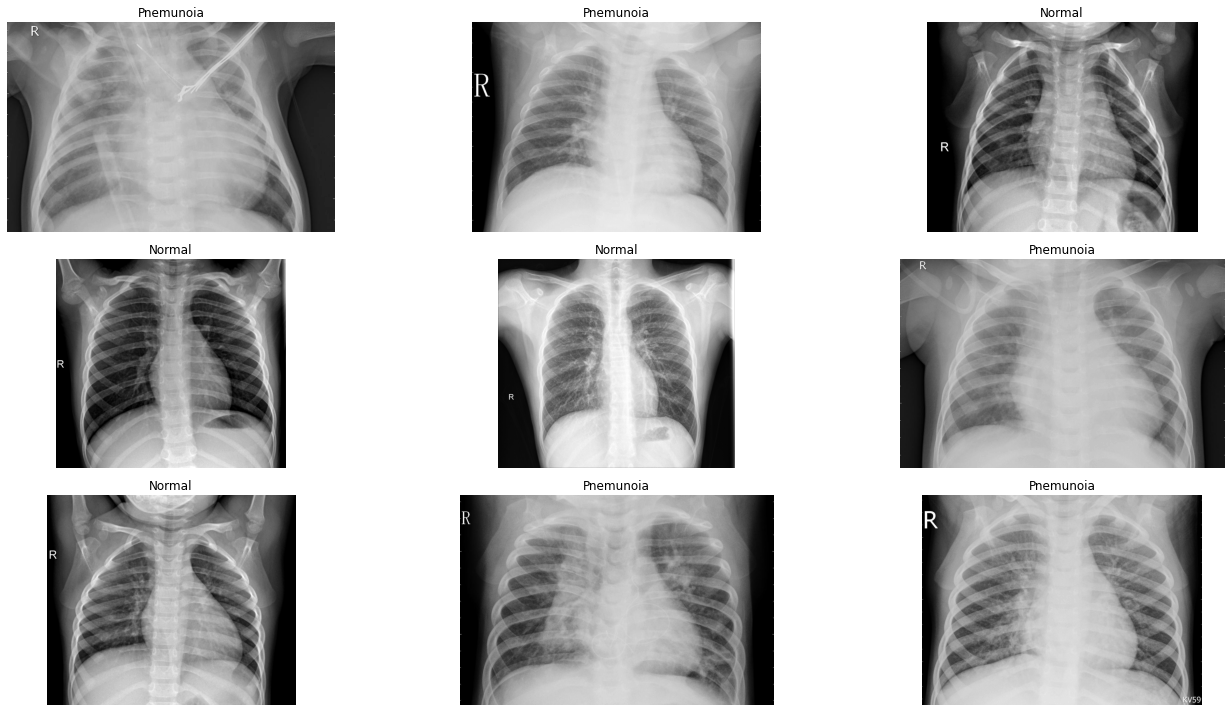

In [ ]:
i = 1

%matplotlib inline
plt.figure(figsize=(20,10))
for row in samples.iterrows():
    plt.subplot(3,3, i)
    i += 1
    label = ""
    if row[1][1] == "PNEUMONIA":
      label = "Pnemunoia"
    else:
      label = "Normal"
    img= imread(row[1][0])
    plt.imshow(img, cmap='gray')
    plt.axis("off")
    plt.title(label)
plt.tight_layout()

##Checking for class imbalance

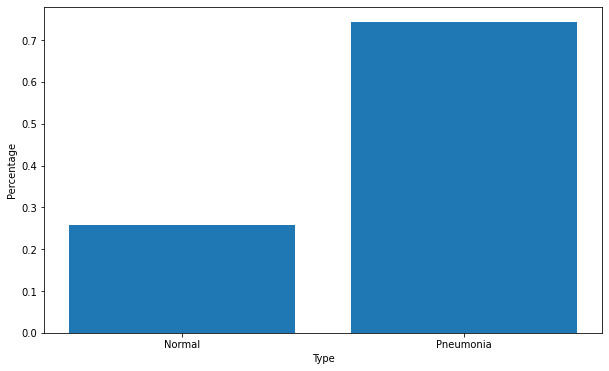

In [ ]:
plt.figure(figsize = (10,6))
plt.bar(["Normal","Pneumonia"],[((df_train['Type'] == "NORMAL") == True).sum() / df_train['Type'].count(), ((df_train['Type'] == "PNEUMONIA") == True).sum() / df_train['Type'].count()])
plt.xlabel('Type')
plt.ylabel('Percentage')
plt.show()

As we can see we are having class imbalance where positive classes are three times more likely to be encountered in the training set.

###Handling the class imbalance

There are many ways to do deal with class imbalance (upsampling, downsampling, different ways to apply class weights...), but we are going for the simplest one which is weighting out the classes using their frequency.

In [ ]:
negativeWeights = ((df_train.Type == "PNEUMONIA") == True).sum() / df_train.Type.count()
positiveWeights = 1 - negativeWeights
weights = { 0 : negativeWeights,
            1 : positiveWeights}
print("Negative ", negativeWeights, " Positive ", positiveWeights )

Negative  0.7429064417177914  Positive  0.2570935582822086


#Training models

In [ ]:
metrics = ['accuracy',   tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')]

##Densenet121

In [ ]:
denseNet = DenseNet121(weights='imagenet', include_top= False, input_shape= (300,300,3), classes = 2)
denseNet.trainable = False
denseNetModel = tf.keras.models.Sequential(layers = [
            denseNet,
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(640, activation = 'relu'),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(128, activation = 'relu'),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(1, activation = 'sigmoid')                                    
])

In [ ]:
denseNetModel.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = metrics)
historyDN121 = denseNetModel.fit(
    train,
    validation_data = val,
    class_weight = weights,
    epochs = 5
)

Epoch 1/5
163/163 [==============================] - 222s 1s/step - loss: 3.0339 - accuracy: 0.7240 - precision: 0.8787 - recall: 0.7321 - val_loss: 0.3582 - val_accuracy: 0.8125 - val_precision: 0.7273 - val_recall: 1.0000
Epoch 2/5
163/163 [==============================] - 175s 1s/step - loss: 0.2630 - accuracy: 0.8689 - precision: 0.9430 - recall: 0.8757 - val_loss: 0.2227 - val_accuracy: 0.9375 - val_precision: 1.0000 - val_recall: 0.8750
Epoch 3/5
163/163 [==============================] - 174s 1s/step - loss: 0.1227 - accuracy: 0.8980 - precision: 0.9607 - recall: 0.8968 - val_loss: 0.1512 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 4/5
163/163 [==============================] - 175s 1s/step - loss: 0.1075 - accuracy: 0.9090 - precision: 0.9638 - recall: 0.9100 - val_loss: 0.1604 - val_accuracy: 0.9375 - val_precision: 1.0000 - val_recall: 0.8750
Epoch 5/5
163/163 [==============================] - 175s 1s/step - loss: 0.0926 - accuracy: 0.9070 - pr

In [ ]:
!ls gdrive/MyDrive/modeli

densenet121.h5	proba.h5


In [ ]:
denseNetModel.save('gdrive/MyDrive/modeli/densenet121.h5')

##Xception

In [ ]:
xception = tf.keras.applications.Xception(include_top = False, weights ='imagenet', classes = 2, input_shape = (300,300,3))
xception.trainable = False
xceptionModel = tf.keras.models.Sequential(layers = [
    xception,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(640, activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation = 'sigmoid')      
 
])
xceptionModel.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = metrics)
historyXC = xceptionModel.fit(
    train,
    validation_data = val,
    epochs = 5,
    class_weight = weights
)

Epoch 1/5
163/163 [==============================] - 193s 1s/step - loss: 2.6944 - accuracy: 0.7838 - precision: 0.8992 - recall: 0.7965 - val_loss: 0.6097 - val_accuracy: 0.7500 - val_precision: 1.0000 - val_recall: 0.5000
Epoch 2/5
163/163 [==============================] - 188s 1s/step - loss: 0.3653 - accuracy: 0.8533 - precision: 0.9501 - recall: 0.8473 - val_loss: 0.3898 - val_accuracy: 0.8125 - val_precision: 1.0000 - val_recall: 0.6250
Epoch 3/5
163/163 [==============================] - 187s 1s/step - loss: 0.1506 - accuracy: 0.8714 - precision: 0.9552 - recall: 0.8679 - val_loss: 0.4596 - val_accuracy: 0.7500 - val_precision: 1.0000 - val_recall: 0.5000
Epoch 4/5
163/163 [==============================] - 186s 1s/step - loss: 0.1264 - accuracy: 0.8886 - precision: 0.9654 - recall: 0.8808 - val_loss: 0.4335 - val_accuracy: 0.8125 - val_precision: 1.0000 - val_recall: 0.6250
Epoch 5/5
163/163 [==============================] - 185s 1s/step - loss: 0.1230 - accuracy: 0.8864 - pr

In [ ]:
xceptionModel.save('gdrive/MyDrive/modeli/xception.h5')

##VGG19

In [ ]:
vgg19 = tf.keras.applications.VGG19(include_top = False, weights="imagenet", classes = 2, input_shape = (300,300,3))
vgg19.trainable = False
vgg19Model = tf.keras.models.Sequential(
    layers = [
          vgg19,
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(640, activation = 'relu'),
          tf.keras.layers.Dropout(0.5),
          tf.keras.layers.Dense(128, activation = 'relu'),
          tf.keras.layers.Dropout(0.5),
          tf.keras.layers.Dense(1, activation = 'sigmoid')     
    ]
)
vgg19Model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = metrics)
historyVGG19 = vgg19Model.fit(
    train,
    validation_data = val,
    epochs = 5,
    class_weight = weights
)

80142336/80134624 [==============================] - 1s 0us/step
Epoch 1/5
163/163 [==============================] - 206s 1s/step - loss: 0.9501 - accuracy: 0.6733 - precision: 0.8539 - recall: 0.6732 - val_loss: 0.3323 - val_accuracy: 0.8125 - val_precision: 0.7273 - val_recall: 1.0000
Epoch 2/5
163/163 [==============================] - 183s 1s/step - loss: 0.1279 - accuracy: 0.8560 - precision: 0.9516 - recall: 0.8487 - val_loss: 0.3387 - val_accuracy: 0.8125 - val_precision: 0.8571 - val_recall: 0.7500
Epoch 3/5
163/163 [==============================] - 185s 1s/step - loss: 0.1340 - accuracy: 0.8499 - precision: 0.9487 - recall: 0.8456 - val_loss: 0.2977 - val_accuracy: 0.8750 - val_precision: 0.8000 - val_recall: 1.0000
Epoch 4/5
163/163 [==============================] - 188s 1s/step - loss: 0.1260 - accuracy: 0.8305 - precision: 0.9668 - recall: 0.7976 - val_loss: 0.2638 - val_accuracy: 0.9375 - val_precision: 0.8889 - val_recall: 1.0000
Epoch 5/5
163/163 [====================

In [ ]:
vgg19Model.save('gdrive/MyDrive/modeli/vgg19.h5')

##Resnet152V2

In [ ]:
resNet152V2 = tf.keras.applications.ResNet152V2(include_top = False, weights = 'imagenet', classes = 2, input_shape = (300,300,3))
resNet152V2.trainable = False
resNet152V2Model = tf.keras.models.Sequential(
    layers = [
          resNet152V2,
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(640, activation = 'relu'),
          tf.keras.layers.Dropout(0.5),
          tf.keras.layers.Dense(128, activation = 'relu'),
          tf.keras.layers.Dropout(0.5),
          tf.keras.layers.Dense(1, activation = 'sigmoid')    
    ]
)
resNet152V2Model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = metrics)
historyresNet152V2 = resNet152V2Model.fit(
    train,
    validation_data = val,
    epochs = 5,
    class_weight = weights
)

234553344/234545216 [==============================] - 2s 0us/step
Epoch 1/5
163/163 [==============================] - 227s 1s/step - loss: 3.7965 - accuracy: 0.8103 - precision: 0.9146 - recall: 0.8230 - val_loss: 0.1328 - val_accuracy: 0.9375 - val_precision: 0.8889 - val_recall: 1.0000
Epoch 2/5
163/163 [==============================] - 212s 1s/step - loss: 0.6198 - accuracy: 0.8804 - precision: 0.9541 - recall: 0.8820 - val_loss: 0.1301 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 3/5
163/163 [==============================] - 214s 1s/step - loss: 0.2237 - accuracy: 0.8942 - precision: 0.9643 - recall: 0.8923 - val_loss: 0.1249 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 4/5
163/163 [==============================] - 215s 1s/step - loss: 0.1735 - accuracy: 0.8832 - precision: 0.9697 - recall: 0.8701 - val_loss: 0.2267 - val_accuracy: 1.0000 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 5/5
163/163 [==================

In [ ]:
resNet152V2Model.save('gdrive/MyDrive/modeli/resNet152V2.h5')

#Evaluating models


Since our validation set is small (only 16 images) we will use test set to make final evaluation of our models. After that we will classify our X-ray scans.

In [ ]:
#Loading previously saved models if needed
denseNet121Model = tf.keras.models.load_model('gdrive/MyDrive/modeli/densenet121.h5', compile= True)
xceptionModel = tf.keras.models.load_model('gdrive/MyDrive/modeli/xception.h5', compile= True)
vgg19Model = tf.keras.models.load_model('gdrive/MyDrive/modeli/vgg19.h5', compile= True)
resNet152V2Model = tf.keras.models.load_model('gdrive/MyDrive/modeli/resNet152V2.h5', compile= True)

In [ ]:
#Collecting predictions of every model
proba_predicitonDenseNet121 = denseNet121Model.predict(test)
proba_predictionXception    = xceptionModel.predict(test)
proba_predictionVGG19       = vgg19Model.predict(test)
proba_predictionResnet152V2 = resNet152V2Model.predict(test)

In [ ]:
#Class labels
y_true = test.classes


##DenseNet121

Model with DenseNet121 in it's core as feature extractor provided 0.96 recall for positive class, here we lowered the threshold by a 0.05 so we can lower the number false negative predictions.

In [ ]:
y_predictionsDenseNet121 = (proba_predicitonDenseNet121 > 0.45).astype('int32')
print(classification_report(y_true, y_predictionsDenseNet121))

              precision    recall  f1-score   support

           0       0.92      0.81      0.86       234
           1       0.89      0.96      0.92       390

    accuracy                           0.90       624
   macro avg       0.91      0.88      0.89       624
weighted avg       0.90      0.90      0.90       624



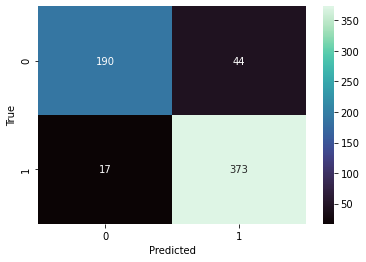

In [ ]:
cmDN121 = confusion_matrix(y_true, y_predictionsDenseNet121)
ax = plt.subplot()
sns.heatmap(cmDN121, annot= True, fmt='g', cmap ='mako')
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
plt.show()

For other models threshold remained as it is, 0.5

##Xception

In [ ]:
y_predictionsXception = (proba_predictionXception > 0.5).astype('int32')
print(classification_report(y_true, y_predictionsXception))

              precision    recall  f1-score   support

           0       0.83      0.88      0.86       234
           1       0.93      0.89      0.91       390

    accuracy                           0.89       624
   macro avg       0.88      0.89      0.88       624
weighted avg       0.89      0.89      0.89       624



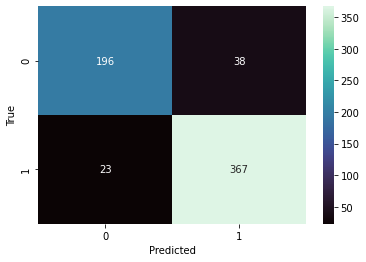

In [ ]:
cmXC = confusion_matrix(y_true, y_predictionsXception)
ax = plt.subplot()
sns.heatmap(cmXC, annot= True, fmt='g', cmap ='mako')
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
plt.show()

##VGG19

In [ ]:
y_predictionsVGG19 = (proba_predictionVGG19 > 0.5).astype('int32')
print(classification_report(y_true, y_predictionsVGG19))

              precision    recall  f1-score   support

           0       0.87      0.84      0.86       234
           1       0.91      0.93      0.92       390

    accuracy                           0.89       624
   macro avg       0.89      0.88      0.89       624
weighted avg       0.89      0.89      0.89       624



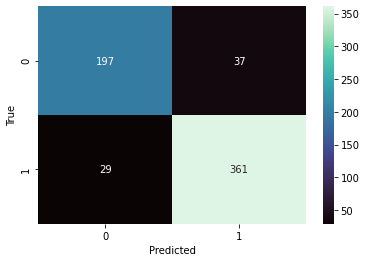

In [ ]:
cmVGG = confusion_matrix(y_true, y_predictionsVGG19)
ax = plt.subplot()
sns.heatmap(cmVGG, annot= True, fmt='g', cmap ='mako')
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
plt.show()

##ResNet152V2

In [ ]:
y_predictionsResNet152V2= (proba_predictionResnet152V2 > 0.5).astype('int32')
print(classification_report(y_true, y_predictionsResNet152V2))

              precision    recall  f1-score   support

           0       0.86      0.89      0.88       234
           1       0.93      0.92      0.92       390

    accuracy                           0.91       624
   macro avg       0.90      0.90      0.90       624
weighted avg       0.91      0.91      0.91       624



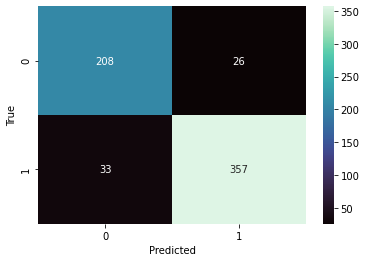

In [ ]:
cmRN = confusion_matrix(y_true, y_predictionsResNet152V2)
ax = plt.subplot()
sns.heatmap(cmRN, annot= True, fmt='g', cmap ='mako')
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
plt.show()

#Testing

By evaluating our models on test set, we gained an insight of how our models are performing. Now we are going to try them on my personal scans where we got two different diagnosis from two different medical experts.

In [ ]:
#loading images
scan1 = imread('gdrive/MyDrive/1.jpeg')
scan2 = imread('gdrive/MyDrive/2.jpeg')
scan3 = imread('gdrive/MyDrive/3.jpeg')

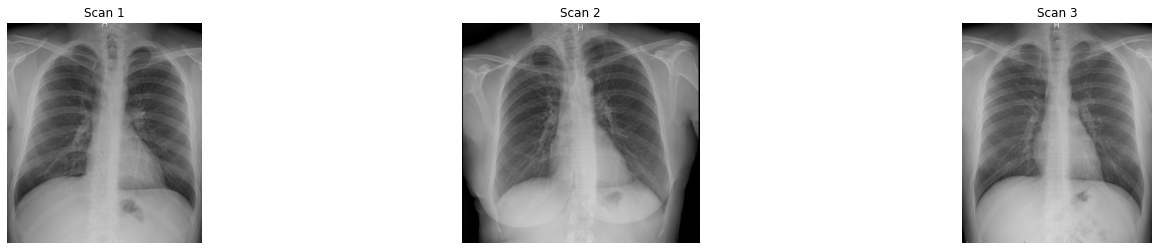

In [ ]:
%matplotlib inline
plt.figure(figsize=(20,10))
plt.subplot(3,3, 1)
plt.title('Scan 1')
plt.imshow(scan1, cmap='gray')
plt.axis("off")
plt.tight_layout()
plt.subplot(3,3,2)
plt.title('Scan 2')
plt.imshow(scan2, cmap='gray')
plt.axis("off")
plt.tight_layout()
plt.subplot(3,3,3)
plt.title('Scan 3')
plt.imshow(scan3, cmap='gray')
plt.axis("off")
plt.tight_layout()

In [ ]:
#Transforming images to expected input size
scan1 = tf.image.random_crop(scan1,[300, 300, 3])
scan1 = np.expand_dims(scan1, axis=0)
scan2 = tf.image.random_crop(scan2,[300, 300, 3])
scan2 = np.expand_dims(scan2, axis=0) 
scan3 = tf.image.random_crop(scan3,[300, 300, 3])
scan3 = np.expand_dims(scan3, axis=0)

##Predictions

In [ ]:
print(denseNet121Model.predict(scan1) > 0.99)
print(denseNet121Model.predict(scan2) > 0.99)
print(denseNet121Model.predict(scan3) > 0.99)

[[ True]]
[[ True]]
[[ True]]


In [ ]:
print(xceptionModel.predict(scan1) > 0.99)
print(xceptionModel.predict(scan2) > 0.99)
print(xceptionModel.predict(scan3) > 0.99)

[[ True]]
[[ True]]
[[ True]]


In [ ]:
print(resNet152V2Model.predict(scan1) > 0.99)
print(resNet152V2Model.predict(scan2) > 0.99)
print(resNet152V2Model.predict(scan3) > 0.99)

[[ True]]
[[ True]]
[[ True]]


In [ ]:
print(vgg19Model.predict(scan1) > 0.99)
print(vgg19Model.predict(scan2) > 0.99)
print(vgg19Model.predict(scan3) > 0.99)

[[False]]
[[False]]
[[ True]]


#Conclusion

For scan number three we've got 4/4 models agreeing that it is a pneumonia case, for the other two scans we've got 3/4. It is worth noting that probabilities that were required were higher than 99% to classify scan as positive for pneumonia and models pretty much achieved similar performance

We can say that the confidence of models is overwhelmingly positive that these are cases of pneumonia, since in real scenario we wouldn't require 99% certainity to diagnose someone as positive with life threatening condition. The decision threshold would be much lower. So can I agree that this is pneumonia? Not, at all, first of all I'm not medical professional, and the second reason is that I'm personally convinced that systems like this one can only be used to provide support for and enhance decision making of medical experts and not completely replace them. On the other hand I know that the ability of the system to predict positive cases is good which is mirrored by it's high recall (0.96 for DenseNet121 model), but that also comes with the cost of somewhat lower precision which is alright, since declaring someone healthy when they are actually ill has far more greater consequences than sending a patient further to do additional anaylisis if the patient was declared as ill by mistake.

---



Since medical data is rather difficult and expensive to collect it would be nice to see a government led strategy that would put focus on collecting X-ray scans, which are now unfortunately abundant, and investing resources on developing intelligent software which can be used in the years to come to make better medical decisions, which will ultimately avoid what happened to my family and me.